PCA 2D explained variance: [0.27919419 0.13231722]

================= RBF SVM =================
Training SVM (rbf) on 112500 rows...
[LibSVM]Accuracy : 0.6386
Precision: 0.5281
Recall   : 0.1077
F1 Score : 0.1790
Training time: 13:57:643366


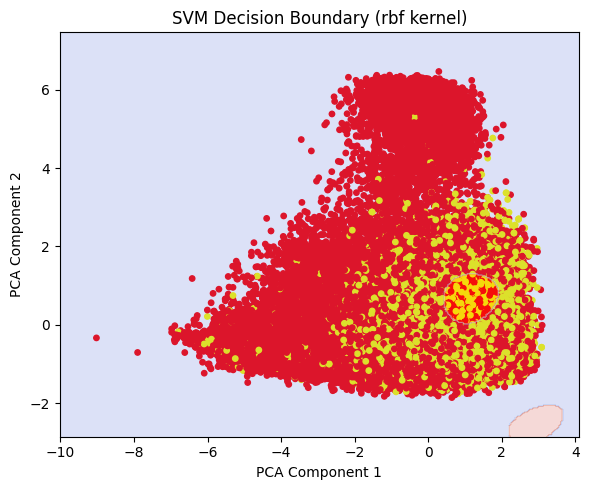


================= SIGMOID SVM =================
Training SVM (sigmoid) on 112500 rows...
[LibSVM]Accuracy : 0.5328
Precision: 0.3595
Recall   : 0.3556
F1 Score : 0.3575
Training time: 16:23:782966


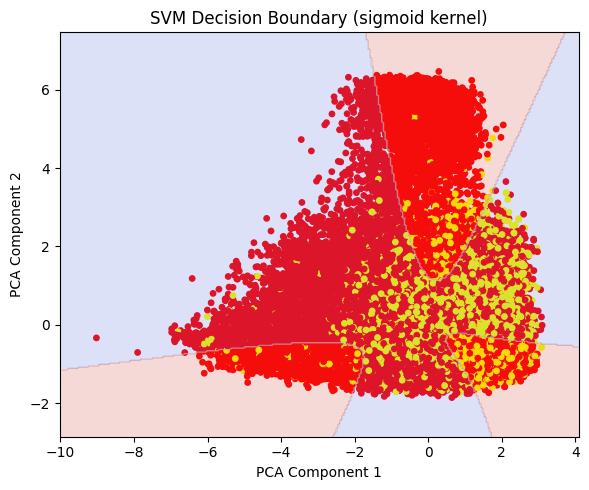

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import datetime

df = pd.read_csv("https://docs.google.com/spreadsheets/d/17CHsjIhvCL4wQyzC6JkDaFUaMIme31RGCkkg-BS18eE/gviz/tq?tqx=out:csv&gid=0")

df = df.sample(n=150000, random_state=42).reset_index(drop=True)

df["popular"] = (df["popularity"] >= 50).astype(int)

num_features = [
    "acousticness","danceability","duration_ms","energy",
    "instrumentalness","liveness","loudness",
    "speechiness","tempo","valence"
]
cat_features = ["genre", "key", "mode", "time_signature"]

X = df[num_features + cat_features]
y = df["popular"].values

# PREPROCESS
preprocess = ColumnTransformer(
    [
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)

X_scaled = preprocess.fit_transform(X).toarray()

# PCA 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print("PCA 2D explained variance:", pca.explained_variance_ratio_)

# Use PCA data for training SVMs
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.25, random_state=42
)

# FUNCTION TO PLOT DECISION BOUNDARY
def plot_decision_boundary(model, X, y, kernel_name):
    plt.figure(figsize=(6,5))

    # Scatter points
    plt.scatter(X[:,0], X[:,1], c=y, cmap='autumn', s=15)

    # Grid
    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.2, cmap="coolwarm")

    plt.title(f"SVM Decision Boundary ({kernel_name} kernel)")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.tight_layout()
    plt.show()

# TRAIN + EVALUATE SVMs FOR KERNELS
kernels = ["rbf", "sigmoid"]

for kernel in kernels:
    print(f"\n================= {kernel.upper()} SVM =================")
    print(f"Training SVM ({kernel}) on {len(X_train)} rows...")

    time0 = time()

    clf = SVC(kernel=kernel, gamma='auto', degree=3, cache_size=5000, verbose=True)
    clf.fit(X_train, y_train)

    train_time = time() - time0

    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print("Training time:", datetime.datetime.fromtimestamp(train_time).strftime("%M:%S:%f"))

    # Plot boundary
    plot_decision_boundary(clf, X_train, y_train, kernel)